In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import torch
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from blocksnet.relations import generate_adjacency_graph
from blocksnet.enums import LandUse
from torch_geometric.nn import GraphSAGE
import torch.nn as nn

blocks = pd.read_pickle('blocks.pickle')

/root/blocksnet/.venv/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/root/blocksnet/.venv/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
blocks['site_length'] = blocks.length
blocks['x'] = blocks.centroid.x
blocks['y'] = blocks.centroid.y
blocks['footprint_area'] /= blocks['site_area']
blocks['build_floor_area'] /= blocks['site_area']
blocks['living_area'] /= blocks['site_area']
blocks = blocks[blocks.area>0].copy()

In [3]:
# Generate full graph
graph = generate_adjacency_graph(blocks, 10)
graph = nx.convert_node_labels_to_integers(graph)
edges_list = list(graph.edges)
edge_index = torch.tensor(edges_list, dtype=torch.long).t().contiguous()

2025-07-14 16:22:21.082 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_nodes:9 - Generating nodes
2025-07-14 16:22:21.086 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_edges:14 - Generating edges
2025-07-14 16:22:22.792 | SUCCESS  | blocksnet.relations.adjacency.core:generate_adjacency_graph:37 - Adjacency graph successfully generated: 9312 nodes, 30110 edges


In [4]:
# Define columns
TARGET_COLUMNS = ['footprint_area', 'build_floor_area', 'living_area']
FEATURE_COLUMNS = ['site_length', 'site_area', 'x', 'y'] + [lu.value for lu in LandUse]

In [5]:
# Feature engineering


def feature_engineering(blocks: pd.DataFrame) -> pd.DataFrame:
    blocks_df = blocks.copy()
    blocks_df['distance_to_center'] = np.sqrt(blocks_df['x']**2 + blocks_df['y']**2)

    # blocks_df['x_normalized'] = blocks_df['x'] / (blocks_df['x'].std() + 1e-8)
    # blocks_df['y_normalized'] = blocks_df['y'] / (blocks_df['y'].std() + 1e-8)
    # blocks_df['lu_diversity'] = blocks_df[[lu.value for lu in LandUse]].sum(axis=1)
    # blocks_df['is_mixed_use'] = (blocks_df[[lu.value for lu in LandUse]].sum(axis=1) > 1).astype(int)
    # blocks_df['site_length_log'] = np.log1p(blocks_df['site_length'])
    # blocks_df['site_length_squared'] = blocks_df['site_length'] ** 2
    # blocks_df['build_density'] = blocks_df['site_area'] / (blocks_df['site_area'] + 1e-8)
    # blocks_df['living_ratio'] = blocks_df['living_area'] / (blocks_df['site_area'] + 1e-8)
    # blocks_df['footprint_ratio'] = blocks_df['site_area'] / (blocks_df['site_length'] + 1e-8)
    feature_columns = FEATURE_COLUMNS + [
        'distance_to_center', #'x_normalized', 'y_normalized',
        # 'lu_diversity', 'is_mixed_use', 'site_length_log', 'site_length_squared',
        #'build_density', 'living_ratio', 'footprint_ratio'
    ]
    return blocks_df[feature_columns + TARGET_COLUMNS]

# Apply feature engineering
blocks = feature_engineering(blocks)

In [6]:
blocks

,site_length,site_area,x,y,residential,business,recreation,industrial,transport,special,agriculture,distance_to_center,footprint_area,build_floor_area,living_area
0,6.386234,0.032316,349423.819885,6.631181e+06,0.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,6.640381e+06,0.000000,0.000000,0.000000
1,2193.855496,137101.088247,351891.243058,6.633885e+06,0.099000,0.0,0.079912,0.000000,0.401072,0.0,0.417018,6.643211e+06,0.000503,0.000503,0.000000
2,1508.777966,95239.084434,346848.697779,6.618497e+06,1.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,6.627579e+06,0.061465,0.064120,0.044070
3,2248.336940,125919.330984,347112.049094,6.618339e+06,0.729125,0.0,0.270875,0.000000,0.000000,0.0,0.000000,6.627435e+06,0.033472,0.034748,0.024093
4,2001.684796,169860.164494,355059.236032,6.618796e+06,0.454375,0.0,0.000000,0.000000,0.144935,0.0,0.399984,6.628313e+06,0.078846,0.183930,0.122813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9363,778.111801,16802.384600,346574.899872,6.647655e+06,0.937805,0.0,0.000000,0.000000,0.062195,0.0,0.000000,6.656683e+06,0.259544,1.282521,0.589891
9364,1001.558725,47637.956433,346205.483186,6.647675e+06,0.125516,0.0,0.266734,0.000000,0.607750,0.0,0.000000,6.656684e+06,0.314110,1.535523,0.000000
9365,1275.728432,64487.699525,343969.796461,6.648982e+06,0.000000,0.0,0.763388,0.000000,0.231754,0.0,0.000000,6.657873e+06,0.000398,0.000398,0.000000
9366,942.417410,42988.399080,346204.925815,6.649575e+06,0.404385,0.0,0.000000,0.471607,0.124008,0.0,0.000000,6.658581e+06,0.301800,1.226781,0.000000


In [7]:
# Split node indices
n_nodes = len(blocks)
node_indices = np.arange(n_nodes)
train_indices, val_indices = train_test_split(
    node_indices, test_size=0.2, random_state=42
)
print(f"Train nodes: {len(train_indices)}, Val nodes: {len(val_indices)}")


Train nodes: 7449, Val nodes: 1863


In [8]:
# Define model
class MultiScaleGNN(nn.Module):
    def __init__(self, input_size: int, output_size: int, hidden_dim: int = 128, 
                 num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        self.output_size = output_size
        self.graphsage = GraphSAGE(
            in_channels=input_size,
            hidden_channels=hidden_dim,
            num_layers=num_layers,
            out_channels=hidden_dim,
            dropout=dropout,
            act='relu',
            norm=nn.LayerNorm(hidden_dim),
        )
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 4, output_size)
        )
    
    def forward(self, x: torch.Tensor, edge_index: torch.Tensor):
        features = self.graphsage(x, edge_index)
        output = self.output_layer(features)
        return output

In [9]:
# Initialize strategy
from blocksnet.machine_learning.strategy.torch.graph.graph_imputation_strategy import TorchGraphImputationStrategy

strategy = TorchGraphImputationStrategy(
    model_cls=MultiScaleGNN,
    scalers={'x': StandardScaler(), 'y': StandardScaler()}
)

In [10]:
# Train model with single graph
x = blocks[blocks.columns.difference(TARGET_COLUMNS)].values
y = blocks[TARGET_COLUMNS].values

train_losses, test_losses = strategy.train(
    x_train=x,
    x_test=x,
    y_train=y,
    y_test=y,
    edge_index=edge_index,
    train_indices=train_indices,
    val_indices=val_indices,
    epochs=100,
    optimizer_params={"lr": 3e-4, "weight_decay": 1e-4},
    data_loader_params={"batch_size": 1, "shuffle": False}
)

Train loss: 0.38167 | Test loss: 0.31223: 100%|██████████| 100/100 [00:04<00:00, 23.83it/s]


In [11]:
import numpy as np

def generate_missing_mask(shape: tuple, missing_rate: float = 0.4) -> np.ndarray:
    mask = np.ones(shape, dtype=bool)
    n_rows, n_cols = shape
    for col in range(n_cols):
        missing_indices = np.random.choice(n_rows, int(n_rows * missing_rate), replace=False)
        mask[missing_indices, col] = False
    return mask

In [12]:
import numpy as np
from sklearn.metrics import r2_score

# Получаем маску для валидационных узлов
val_mask = np.zeros(len(blocks), dtype=bool)
val_mask[val_indices] = True
imputation_mask = generate_missing_mask(
    shape=(len(blocks), len(TARGET_COLUMNS)), missing_rate=0.4
)

# Предсказания только для валидационных узлов
predictions = strategy.predict(
    x=blocks[blocks.columns.difference(TARGET_COLUMNS)].values,
    edge_index=edge_index,
    y=blocks[TARGET_COLUMNS].values,
    imputation_mask=imputation_mask,
)

# Истинные значения для валидационных узлов
y_true = blocks[TARGET_COLUMNS].values[val_indices]

# R² для каждого таргета
for i, col in enumerate(TARGET_COLUMNS):
    r2 = r2_score(y_true[:, i], predictions[:, i][val_indices])
    print(f"{col}: R² = {r2:.4f}")

# Если нужен общий R² для всех таргетов:
r2_total = r2_score(y_true, predictions[val_indices])
print(f"Total R²: {r2_total:.4f}")

footprint_area: R² = 0.5513
build_floor_area: R² = 0.6826
living_area: R² = 0.5590
Total R²: 0.5976



=== Plotting Loss Curves ===


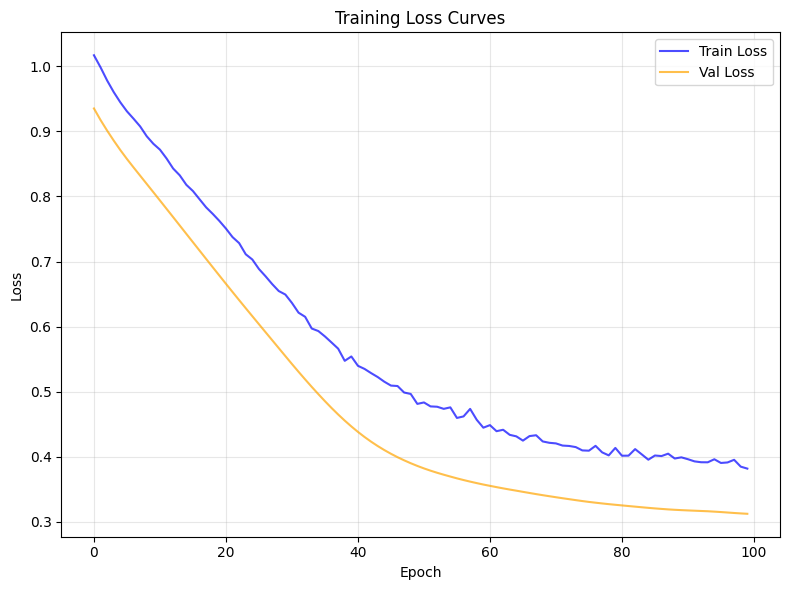

In [13]:
import matplotlib.pyplot as plt
from typing import List

# Функция для отображения только потерь
def plot_losses(train_losses: List[float], test_losses: List[float], title: str):
    """
    Plot training and test losses over epochs.
    """
    print("\n=== Plotting Loss Curves ===")
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Train Loss', alpha=0.7, color='blue')
    plt.plot(test_losses, label='Val Loss', alpha=0.7, color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Вызов функции (передайте соответствующие списки)
plot_losses(train_losses, test_losses, title='Training Loss Curves')


In [14]:
# Save model
strategy.save('./graph_imputation_model')

# Load model
strategy = TorchGraphImputationStrategy(model_cls=MultiScaleGNN)
strategy.load('./graph_imputation_model')

/root/blocksnet/blocksnet/machine_learning/strategy/torch/base_strategy.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)
